# Credal sets and classifiers

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import chain, combinations

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from sklearn.datasets import make_blobs, load_wine

import mpltern
import warnings

from scipy.stats import dirichlet

The theory of imprecise probabilities (Walley, 1991) is largely built on the idea to specify
knowledge in terms of a set $Q$ of probability distributions instead of a single distribution.
In the literature, such sets are also referred to as *credal sets*, and often assumed to be
convex (i.e.,$q , q' \in Q$ implies $\alpha q + (1-\alpha) q' \in Q$ for all $\alpha \in [0,1]$).
The concept of credal
sets and related notions provide the basis of a generalization of Bayesian inference, which
is especially motivated by the criticism of non-informative priors as models of ignorance
in standard Bayesian inference (cf. Section 3.3). The basic idea is to replace a single
prior distribution on the model space, as used in Bayesian inference, by a (credal) set of
candidate priors. Given a set of observed data, Bayesian inference can then be applied
to each candidate prior, thereby producing a (credal) set of posteriors. Correspondingly,
any value or quantity derived from a posterior (e.g., a prediction, an expected value,
etc.) is replaced by a set of such values or quantities. An important example of such
an approach is robust inference for categorical data with the imprecise Dirichlet model,
which is an extension of inference with the Dirichlet distribution as a conjugate prior for
the multinomial distribution (Bernardo, 2005).

Methods of that kind have also been used in the context of machine learning, for example in the framework of the Na\"ive Credal Classifier \citep{zaffalon2002,cora_lr08} or more recently as an extension of sum-product networks \citep{dera_cs17}. As for the former, we can think of a Na\"ive Bayes (NB) classifier as a hypothesis $h = h_{\vec{\theta}}$ specified by a parameter vector ${\vec{\theta}}$ that comprises a prior probability $\theta_k$ for each class $y_k \in \set{Y}$ and a conditional probability $\theta_{i,j,k}$ for observing the $i^{th}$ value $a_{i,j}$ of the $j^{th}$ attribute given class $y_k$. For a given query instance specified by attributes $(a_{i_1,1}, \ldots , a_{i_J,J})$, the posterior class probabilities are then given by
$$
\begin{equation}\label{eq:spo}
p(y_k | a_{i_1,1}, \ldots , a_{i_J,J}) \propto \theta_k \prod_{j=1}^J \theta_{i_j,j,k} \, .
\end{equation}
$$

For illustration we use the wine dataset.  We discretize it to make it suitable for categorical naive bayes and also drop some attributes to introduce more uncertainty:

In [3]:
# Load the Wine dataset

columns = [0, 1, 2, 3]
wine = load_wine()
X = wine.data[:,columns]
y = wine.target

target_names = wine.target_names
feature_names = np.array(wine.feature_names)[columns]

In [4]:
# discretize data 
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
X_binned = discretizer.fit_transform(X)

# create df for visualization
bin_labels = ['low', 'medium', 'high']
X_binned_labeled = pd.DataFrame(X_binned, columns=feature_names).applymap(lambda x: bin_labels[int(x)])
y_df = pd.DataFrame(y, columns=['target'])
y_df['target_name'] = y_df['target'].map(lambda x: target_names[x])
wine_df = pd.concat([X_binned_labeled, y_df], axis=1)

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_binned, y, test_size=0.2, random_state=42)                                                                   

In [5]:
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,target,target_name
0,high,low,medium,low,0,class_0
1,medium,low,medium,low,0,class_0
2,medium,low,high,medium,0,class_0
3,high,low,medium,low,0,class_0
4,medium,medium,high,medium,0,class_0


When we train a regular categorical Naive Bayes classifier the prior probabilities $\theta_k$ for each class are calculated as the relative frequencies of class $k$ in the whole dataset. The conditionals $\theta_{i,j,k}$ as the share of observations belonging to class $k$ out of all observations for which attribute $j$ has value $i$:

In [6]:
# init categori1cal NB without laplace smoothing
model = CategoricalNB(alpha=1.)

# train NB
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model.fit(X_train, y_train)

# get prior probabilites from model
prior_probabilities = np.exp(model.class_log_prior_).round(3)
print('Prior probabilities:\n%s'%{c : p for c, p in zip(target_names, prior_probabilities)})

Prior probabilities:
{'class_0': 0.317, 'class_1': 0.401, 'class_2': 0.282}


In [7]:
# get conditional probabilities from model
conditionals = model.feature_log_prob_

conditionals_alcohol = np.exp(conditionals[0]).round(3)

values = ['low', 'medium', 'high']
print('Conditional probabilities of feature 1 values given targets:')
{c: {v : conditionals_alcohol[i][j] for j, v in enumerate(['low', 'medium', 'high'])}
 for i, c in enumerate(target_names)}

Conditional probabilities of feature 1 values given targets:


{'class_0': {'low': 0.021, 'medium': 0.396, 'high': 0.583},
 'class_1': {'low': 0.55, 'medium': 0.4, 'high': 0.05},
 'class_2': {'low': 0.093, 'medium': 0.651, 'high': 0.256}}

After that point predictions are made by computing the likelihood of a query as the product of the respective priors and conditionals:

In [8]:
point_predictions = model.predict_proba(X_test).round(3)
point_predictions[:10]

array([[0.898, 0.032, 0.07 ],
       [0.205, 0.048, 0.747],
       [0.08 , 0.111, 0.809],
       [0.828, 0.064, 0.109],
       [0.042, 0.929, 0.029],
       [0.828, 0.064, 0.109],
       [0.009, 0.655, 0.336],
       [0.057, 0.159, 0.784],
       [0.038, 0.91 , 0.051],
       [0.057, 0.159, 0.784]])

In the Na\"ive Credal Classifier, the $\theta_k$ and $\theta_{i_j,j,k}$ are specified in terms of (local) credal sets\footnote{These could be derived from empirical data, for example, by doing generalized Bayesian inference with the imprecise Dirichlet model.}, i.e., there is a class of probability distributions $Q$ on $\set{Y}$ playing the role of candidate priors, and a class of probability distributions $Q_{j,k}$ specifying possible distributions on the attribute values of the $j^{th}$ attribute given class $y_k$. A single posterior class probability (\ref{eq:spo}) is then replaced by the set (interval) of such probabilities that can be produced by taking $\theta_k$ from a distribution in $Q$ and $\theta_{i_j,j,k}$ from a distribution in $Q_{j,k}$. As an aside, let us note that the computations involved may of course become costly. 

To obtain the credal sets over priors and conditionals the imprecise dirchlet model can be used. The key idea is to model uncertainty about the observations by drawing random samples around them from a dirichlet distribution. For this the concentration parameters $\alpha=(\alpha_{1},...,\alpha_{k})$ of the dirichlet distribution are parametrized as $st$. The empirical priors and conditionals as used in the normal Naive Bayes are used as the parameter $t$:

In [10]:
s = 5
t = prior_probabilities
prior_credal = dirichlet(s*t).rvs(size=3)
print(f'Empirical prior:{prior_probabilities}\nPrior credal_set:' )
prior_credal.round(4)

Empirical prior:[0.317 0.401 0.282]
Prior credal_set:


array([[0.4784, 0.2556, 0.266 ],
       [0.2228, 0.7245, 0.0527],
       [0.1298, 0.3619, 0.5083]])

The parameter $s > 0$ is a fixed constant that can be used to express the degree of believe into the observations. Choosing $s$ to be high will cause the distribution to be more concentrated around $t$. Thus the distribution is less spread out and the uncertainty reduced.

In [12]:
def create_ternary_plots(t):
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5), subplot_kw={'projection': 'ternary'})
    s_vals= [3, 20, 100]
    
    for i, ax in enumerate(axes):
        s = s_vals[i]
        samples = dirichlet(s*t).rvs(size=1000)
        
        ax.scatter(samples[:,0], samples[:,1], samples[:,2], marker='.', s=10, alpha=0.5, color='blue')
        ax.scatter(t[0], t[1], t[2], color='red')
        ax.set_title(f's={s}')
    fig.text(0.5, 0.01, 'Credal sets generated by dirichlet model for different values of s.\n Each blue point corresponds to one distribution, the red point to the empirical distribution.', 
                           ha='center', fontsize=12)
    plt.show()

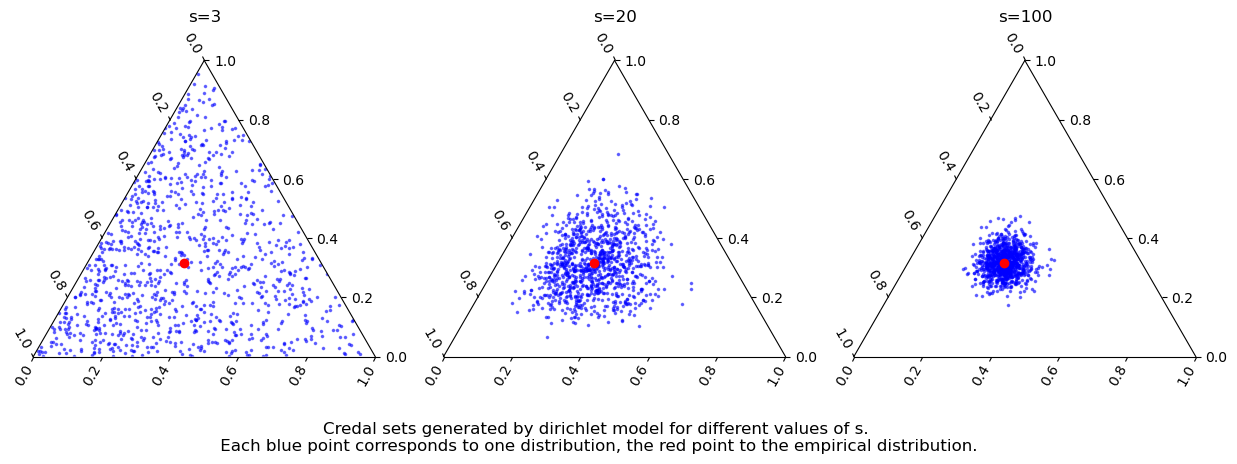

In [13]:
create_ternary_plots(t)

The Naive Credal Classifier produces set predictions as credal sets of posterior distributions. This is done by computing a posterior distribution for each combination of prior and conditional distributions out of the prior and conditional credal sets. While this is impractical we can approximate the true solution by computing the posterior for a fixed number of samples from the prior and posterior credal sets:

In [14]:
class CategoricalNCC:
    
    def fit(self, X, y):
        self.model = CategoricalNB()
        self.model.fit(X, y)
        
        self.n_classes = len(np.unique(y))
        self.data_size = len(y)
        self.class_frequencies = np.exp(self.model.class_log_prior_)
        self.conditional_frequencies = [np.exp(p) for p in 
                                        self.model.feature_log_prob_]
        
    def predict(self, X, sample_size, s=5):
        
        #s = self.data_size / 10
        
        posterior_credal_sets = []
        
        for i in range(sample_size):
            
            # sample priors
            dirichlet_priors = np.log(dirichlet(s*self.class_frequencies).rvs(size=1))
            
            # sample conditionals
            dirichlet_conditionals = [np.array([np.log(dirichlet(s*freq).rvs(size=1)[0]) for freq in feature]) 
                                               for feature in self.conditional_frequencies]
            
            model = self.model
            model.class_log_prior_ = dirichlet_priors
            model.feature_log_prob_ = dirichlet_conditionals
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                pred = model.predict_proba(X)
            
            posterior_credal_sets.append(pred)
            
        posterior_credal_sets = np.transpose(np.array(posterior_credal_sets), (1,0,2)).round(3)
        
        return np.array(posterior_credal_sets).round(3)

With this we can train the Naive Credal Classifier on the test data and obtain a posterior credal set for each query in the training data. Each distribution in the credal represents probabilities for each class equivalently to the point predictions obtained earlier. This resulting credal set could now be analyzed using the methods below. Prediction could be made in the form of set predictions as discussed in link section...

In [15]:
model = CategoricalNCC()
model.fit(X_train,y_train)

In [16]:
wine_credal_sets = model.predict(X_test, 1000, s=50)

In [17]:
wine_credal_sets.shape

(36, 1000, 3)

In [18]:
# first duistributions of posterior credal set for first query
wine_credal_sets[0][:10]

array([[0.949, 0.01 , 0.041],
       [0.874, 0.072, 0.053],
       [0.78 , 0.024, 0.196],
       [0.785, 0.13 , 0.084],
       [0.935, 0.026, 0.039],
       [0.935, 0.013, 0.052],
       [0.94 , 0.048, 0.012],
       [0.88 , 0.014, 0.106],
       [0.925, 0.01 , 0.065],
       [0.865, 0.054, 0.081]])

In [19]:
# point prediction for first query
point_predictions[0]

array([0.898, 0.032, 0.07 ])

In [84]:
def create_posterior_plot(credal_sets, point_predictions, ridx):
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5), subplot_kw={'projection': 'ternary'})
    
    for i, ax in enumerate(axes):

        credal_set = credal_sets[ridx[i]]
        point = point_predictions[ridx[i]]
        
        ax.scatter(credal_set[:,0], credal_set[:,1], credal_set[:,2], marker='.', s=10, alpha=0.5, color='blue')
        #ax.scatter(*credal_set[:,:], marker='.', s=10, alpha=0.5, color='blue')
        ax.scatter(*point, color='red')
        ax.set_title(f'')
    fig.text(0.5, 0.01, """Posterior credal sets for three random queries. Point prediction in red""", 
                           ha='center', fontsize=12)
    plt.show()

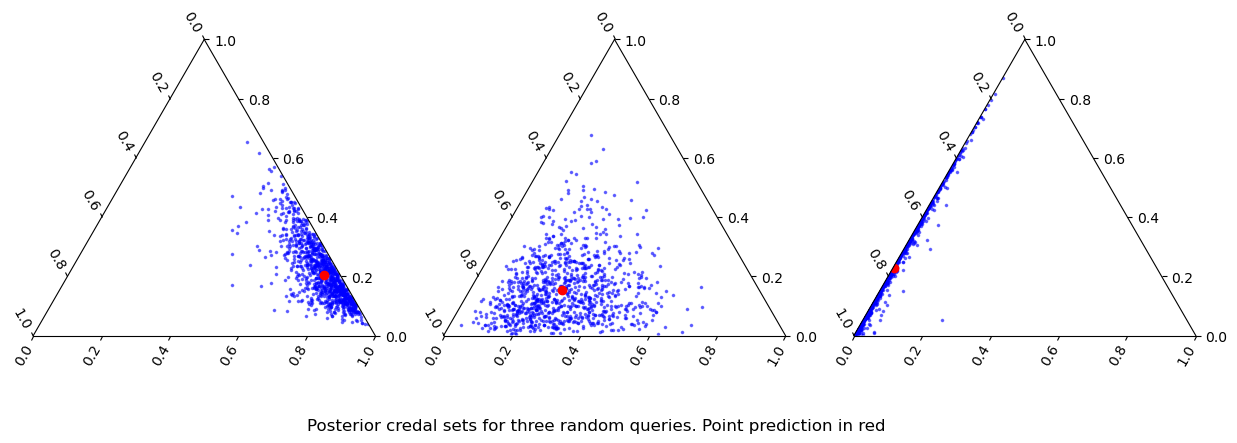

In [87]:
# visualize credal sets of 3 random queries
ridx = np.random.choice(np.arange(len(wine_credal_sets)),3)
create_posterior_plot(wine_credal_sets, point_predictions, ridx)

## Uncertainty measures for credal sets

Interestingly, there has been quite some work on defining uncertainty measures for credal sets and related representation, such as Dempster-Shafer evidence theory \citep{klir_mo94}. Even more interestingly, a basic distinction between two types of uncertainty contained in a credal set, referred to as *conflict* (randomness, discord) and *non-specificity*, respectively, has been made by \cite{yage_ea83}. The importance of this distinction was already emphasized by \cite{kolm_ta65}. These notions are in direct correspondence with what we call aleatoric and epistemic uncertainty. 

The standard uncertainty measure in classical possibility theory (where uncertain information is simply represented in the form of subsets $A \subseteq \mathcal{Y}$ of possible alternatives) is the Hartley measure\footnote{Be aware that we denote both the Hartley measure and the Shannon entropy by $H$, which is common in the literature. The meaning should be clear from the context.}  \citep{hart_to28}

$$
\begin{equation}\label{eq:hartley}
H(A) = \log( |A|)  \, ,
\end{equation}
$$



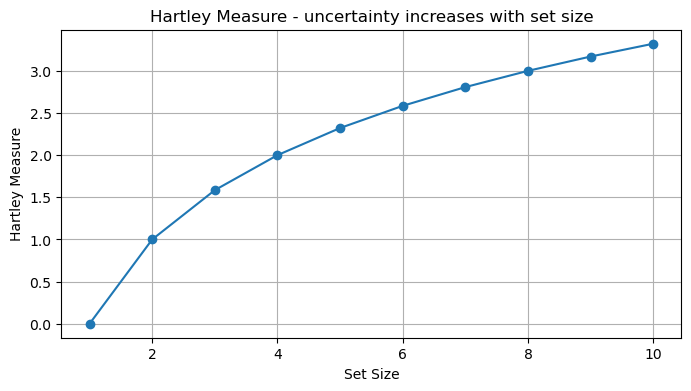

In [22]:
def hartley_measure(A):
    return np.log2(len(A))

set_sizes = range(1, 11)
hartley_values = [hartley_measure(set(range(1, size + 1))) for size in set_sizes]

plt.figure(figsize=(8, 4))
plt.plot(set_sizes, hartley_values, marker='o')
plt.title('Hartley Measure - uncertainty increases with set size')
plt.xlabel('Set Size')
plt.ylabel('Hartley Measure')
plt.grid(True)
plt.show()

Just like the Shannon entropy (\ref{eq:shannon}), this measure can be justified axiomatically\footnote{For example, see Chapter IX, pages 540--616, in the book by \cite{reny_pt}.}. 

Given the insight that conflict and non-specificity are two different, complementary sources of uncertainty, and standard (Shannon) entropy and (\ref{eq:hartley}) as well-established measures of these two types of uncertainty, a natural question in the context of credal sets is to ask for a generalized representation

$$
\begin{equation}\label{eq:aggregate}
\text{U}(Q) = \text{AU}(Q) + \text{EU}(Q) \, ,
\end{equation}
$$

where $\text{U}$ is a measure of total (aggregate) uncertainty, $\text{AU}$ a measure of aleatoric uncertainty (conflict, a generalization of the Shannon entropy), and $\text{EU}$ a measure of epistemic uncertainty (non-specificity, a generalization of the Hartely measure). 

As for the non-specificity part in (\ref{eq:aggregate}), the following generalization of the Hartley measure to the case of graded possibilities has been proposed by various authors \citep{abel_an00}:

$$
\begin{equation}\label{eq:gh}
\text{GH}(Q) \defeq  \sum_{A \subseteq \mathcal{Y}} \text{m}_Q(A) \, \log(|A|) \,,
\end{equation}
$$

where $\text{m}_Q: \,  2^{\mathcal{Y}} \longrightarrow [0,1]$ is the M\"obius inverse of the capacity function $\nu :\, 2^{\mathcal{Y}} \longrightarrow [0,1]$ defined by

\begin{equation}\label{eq:cap}
\nu_Q(A) \defeq \inf_{q \in Q} q(A) 
\end{equation}

for all $A \subseteq \mathcal{Y}$, that is,

$$
\text{m}_Q(A) = \sum_{B \subseteq A} (-1)^{|A \setminus B|} \nu_Q(B) \, .
$$

The measure (\ref{eq:gh}) enjoys several desirable axiomatic properties, and its uniqueness was shown by \cite{klir_ot87}.

In [23]:
def get_powerset(A):
    
    s = list(A)
    return {frozenset(comb) for comb in chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))}

def vq(A, credal_sets):
    
    idx = list(A)
    vq = np.min(np.sum(credal_sets[:,:,idx], axis=2), axis=1)

    return vq
    
def mq(A, credal_sets):
    
    # get powerset
    powerset = get_powerset(A)
    
    # compute mq as moebius inv of capacity vq
    mq = np.sum(np.array([(((-1)**len(A-B))*vq(B, credal_sets)) for B in powerset]),axis=0)
    
    return mq
    
def get_gh_measure(credal_sets):
    
    # add axis if single set
    if len(credal_sets.shape) == 2:
        credal_sets = credal_sets[np.newaxis, :, :]
        
    # compute powerset over classes
    n_classes = credal_sets.shape[-1]
    powerset = get_powerset({idx for idx in range(n_classes)})
    
    # compute GH measure
    GH = np.sum(np.array([mq(A, credal_sets)*hartley_measure(A) 
                 for A in powerset if len(A)]),axis=0)
    
    return GH

To demonstrate the different uncertainty measures another simple dataset consisting of three gaussians will be used:

In [30]:
# generate dataset
X, y = make_blobs(n_samples=200, centers=3, n_features=2, random_state=0, cluster_std=2.)

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

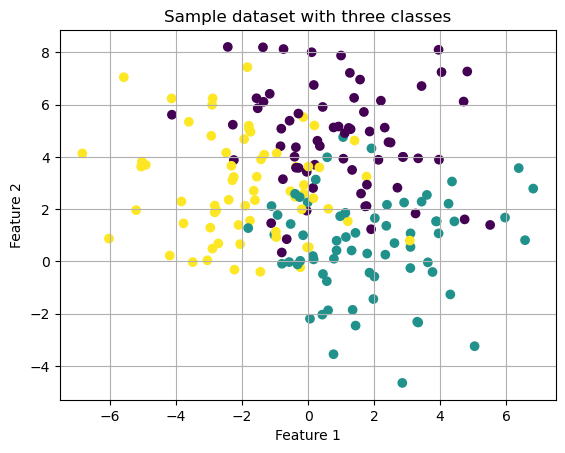

In [31]:
# visualize dataset
plt.scatter(X[:,0], X[:,1], c=y)
plt.title('Sample dataset with three classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

Three Gaussian Naive Bayes classifiers are trained on different subsets of the dataset to produce predictions. Their predictions are then combined into a credal set. The idea is to obtain three conflicting classifiers and a simple credal set. This allows us to easily visualize the impact of aleatoric and epistemic uncertainty on the differnt measures:

In [32]:
# train three Naive bayes classifiers on subsets of training data

classifiers = []

for _ in range(3):
    indices = np.random.choice(len(X_train), 30, replace=False)
    X_subset, y_subset = X_train[indices], y_train[indices]
    
    model = GaussianNB()
    model.fit(X_subset, y_subset)
    
    classifiers.append(model)

In [33]:
def get_posterior_credal_set(X, classifiers):
    
    # get posterior class probabilities
    probabilities = [classifier.predict_proba(X) 
                     for classifier in classifiers]
    
    # combine posteriors into credal sets
    credal_sets = np.transpose(np.array(probabilities), (1,0,2))
    credal_sets = np.round(credal_sets, 3)
    return credal_sets

In [34]:
credal_sets = get_posterior_credal_set(X_test, classifiers).round(4)
credal_sets[0]

array([[0.762, 0.035, 0.202],
       [0.938, 0.039, 0.023],
       [0.775, 0.033, 0.192]])

In [35]:
credal_sets.shape

(60, 3, 3)

We can visualize the decision boundaries of the three classifiers to understand where they will generate conflicting predictions. Those are the areas in which we expect a high epistemic uncertainty whereas the areas where the gaussians overlap should show a high aleatoric uncertainty.

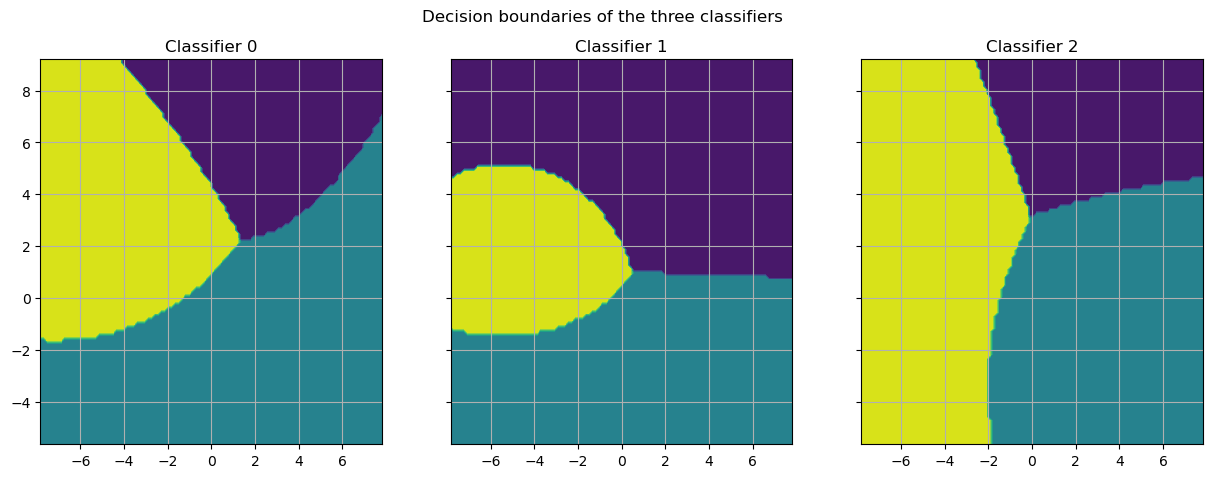

In [36]:
def plot_decision_boundary(model, ax, X, title):
    
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
    x = np.linspace(x_min,x_max, 100)
    y = np.linspace(y_min, y_max, 100)

    xv, yv = np.meshgrid(x,y)
    
    points = np.column_stack((xv.ravel(), yv.ravel()))
    
    labels = model.predict(points).reshape((100,100))
    #plt.contourf(x,y,labels,cmap='RdBu')
    #plt.show()
    ax.contourf(x, y, labels, cmap='viridis', alpha=1.)
    ax.set_title(title)
    ax.grid(True)
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
for i, ax in enumerate(axes.flatten()):
    plot_decision_boundary(classifiers[i], ax, X, f'Classifier {i}')
plt.suptitle('Decision boundaries of the three classifiers')
plt.show()

Now we compute a first uncertainty measure on our posterior credal sets by computing the generalized hartley measure on them. We can get a feeling for it by inspecting the credal sets for which the measure is the lowest and the highest:

In [37]:
gh = get_gh_measure(credal_sets)

In [38]:
credal_sets[np.argmax(gh)]

array([[0.022, 0.018, 0.96 ],
       [0.88 , 0.033, 0.087],
       [0.05 , 0.   , 0.95 ]])

In [39]:
credal_sets[np.argmin(gh)]

array([[0.015, 0.978, 0.007],
       [0.011, 0.989, 0.   ],
       [0.007, 0.991, 0.002]])

In [43]:
def plot_measure_contour(X, y, measure, classifiers, title):
    # helper function to uniformly visualize uncertainty measures
    
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
    x_grid = np.linspace(x_min,x_max, 100)
    y_grid = np.linspace(y_min, y_max, 100)
    
    xv, yv = np.meshgrid(x_grid,y_grid)
    
    points = np.column_stack((xv.ravel(), yv.ravel()))
    
    mesh_probabilities = []

    for classifier in classifiers:
        p = classifier.predict_proba(points)
        mesh_probabilities.append(p)

    mesh_credal_sets = np.transpose(np.array(mesh_probabilities), (1,0,2))
    measure_res = measure(mesh_credal_sets).reshape((100,100))
    
    fig = plt.figure(figsize=(14,6))
    gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    cax = fig.add_subplot(gs[0, 2])
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.grid(True)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    ax2.grid(True)
    
    ax1.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
    contour = ax2.contourf(x_grid, y_grid, measure_res, cmap='viridis')

    cbar = plt.colorbar(contour, cax=cax)

    plt.suptitle(title)
    plt.show()

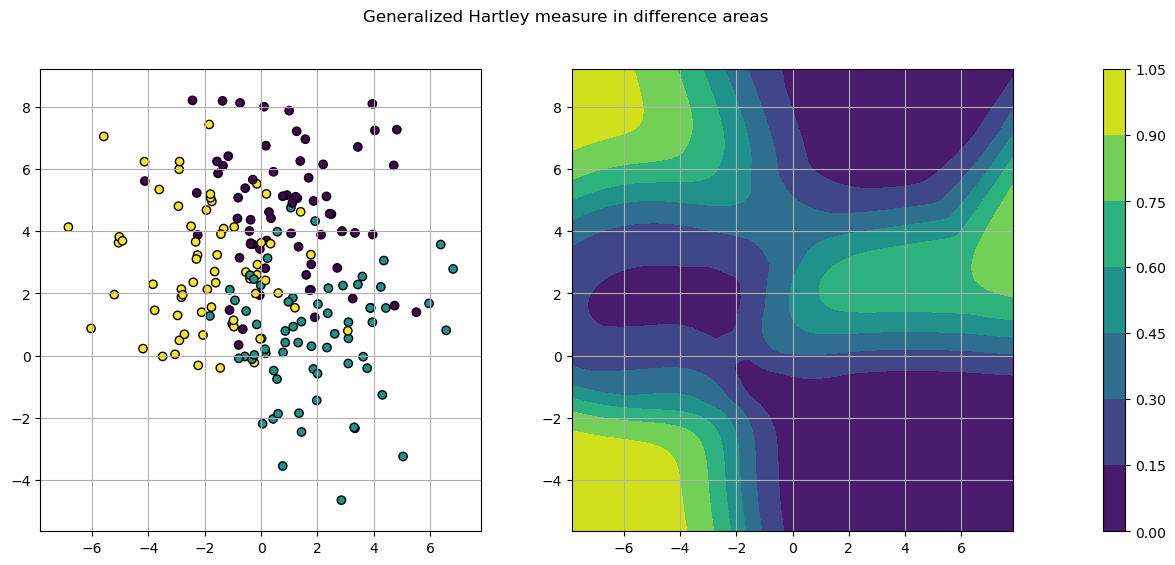

In [45]:
title = 'Generalized Hartley measure in difference areas'
plot_measure_contour(X, y, get_gh_measure, classifiers, title)

For a different illustration we also compute the uncertainty measures on the posterior credal set of the wine data that we obtained earlier and visualize the credal sets with the highest and lowest uncertainty:

In [129]:
def plot_uncertainty_triangle(credal_sets, measure_res, name):
	fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5), subplot_kw={'projection': 'ternary'})

	ridx = [np.argmin(measure_res), np.argmax(measure_res)]
	val = [np.min(measure_res).round(3), np.max(measure_res).round(3)]
    
	for i, ax in enumerate(axes):

		credal_set = credal_sets[ridx[i]]
		point = point_predictions[ridx[i]]
        
		ax.scatter(credal_set[:,0], credal_set[:,1], credal_set[:,2], marker='.', s=10, alpha=0.5, color='blue')
        #ax.scatter(*credal_set[:,:], marker='.', s=10, alpha=0.5, color='blue')
		ax.scatter(*point, color='red')
		ax.set_title(f'{val[i]}')
	fig.text(0.5, 0.01, f"""Credal sets for minimal and maximal {name} measure.""", 
                           ha='center', fontsize=12)
	plt.show()

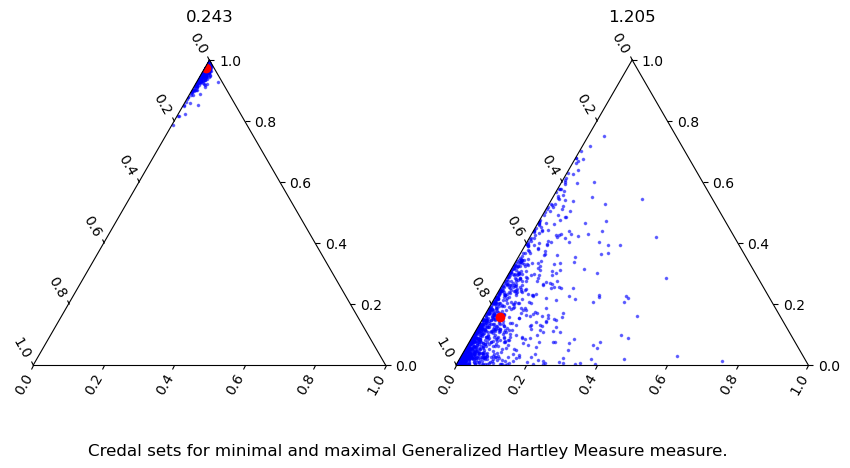

In [130]:
wine_hartley_measure = get_gh_measure(wine_credal_sets)

name = 'Generalized Hartley Measure'
plot_uncertainty_triangle(wine_credal_sets, wine_hartley_measure, name)

The generalization of the Shannon entropy $H$ as a measure of conflict turned out to be more difficult. The upper and lower Shannon entropy play an important role in this regard: 

$$
\begin{equation}\label{eq:gg}
H^*(Q) \defeq \max_{q \in Q} H(q) \, , \quad
H_*(Q) \defeq \min_{q \in Q} H(q)
\end{equation}
$$


In [46]:
def get_shannon_entropy(credal_sets):
    
    # add axis if single set
    if len(credal_sets.shape) == 2:
        credal_sets = credal_sets[np.newaxis, :, :]
    
    shannon = -np.sum(credal_sets * np.log2(credal_sets+1e-50), axis=2)
    
    return shannon

def get_upper_shannon(credal_sets):
    
    # add axis if single set
    if len(credal_sets.shape) == 2:
        credal_sets = credal_sets[np.newaxis, :, :]
    
    shannon = get_shannon_entropy(credal_sets)
    
    upper_shannon = np.max(shannon, axis=1)
    
    upper_shannon = np.round(upper_shannon, 4)
    
    return upper_shannon

def get_lower_shannon(credal_sets):
    
    # add axis if single set
    if len(credal_sets.shape) == 2:
        credal_sets = credal_sets[np.newaxis, :, :]
    
    shannon = get_shannon_entropy(credal_sets)
    
    lower_shannon = np.min(shannon, axis=1)
    
    lower_shannon = np.round(lower_shannon, 4)
    
    return lower_shannon

With this we can compute the upper and lower shannon entropy on our credal sets. Again we look at the credal sets that show the lowest and highest uncertainty and visualize the measure:

In [47]:
upper_shannon = get_upper_shannon(credal_sets)

In [48]:
credal_sets[np.argmax(upper_shannon)]

array([[0.333, 0.137, 0.53 ],
       [0.647, 0.078, 0.276],
       [0.382, 0.28 , 0.338]])

In [49]:
credal_sets[np.argmin(upper_shannon)]

array([[0.015, 0.978, 0.007],
       [0.011, 0.989, 0.   ],
       [0.007, 0.991, 0.002]])

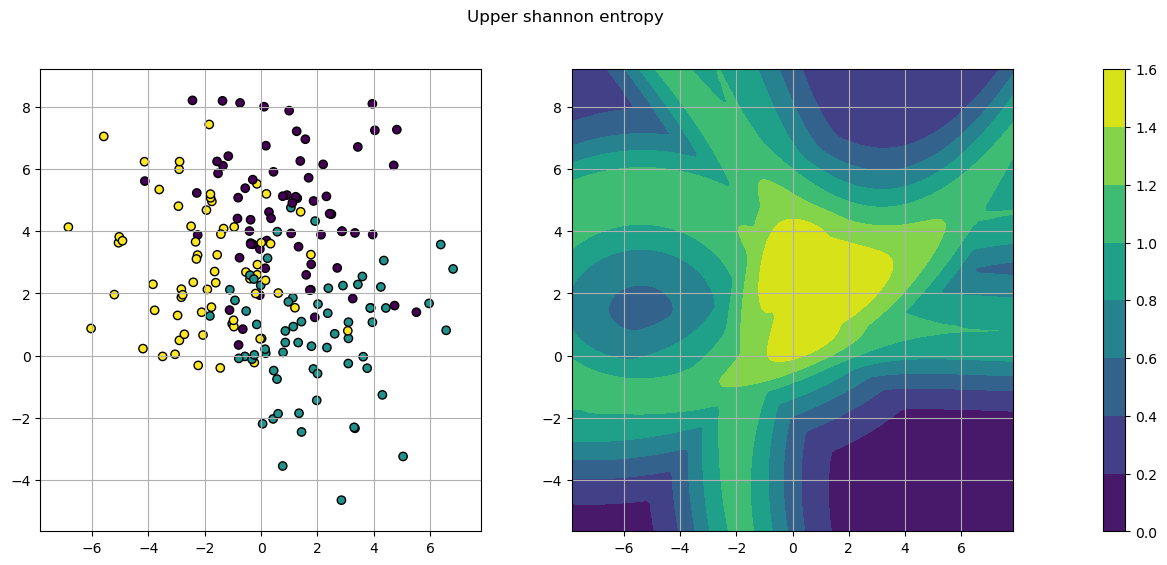

In [51]:
plot_measure_contour(X, y, get_upper_shannon, classifiers, 'Upper shannon entropy')

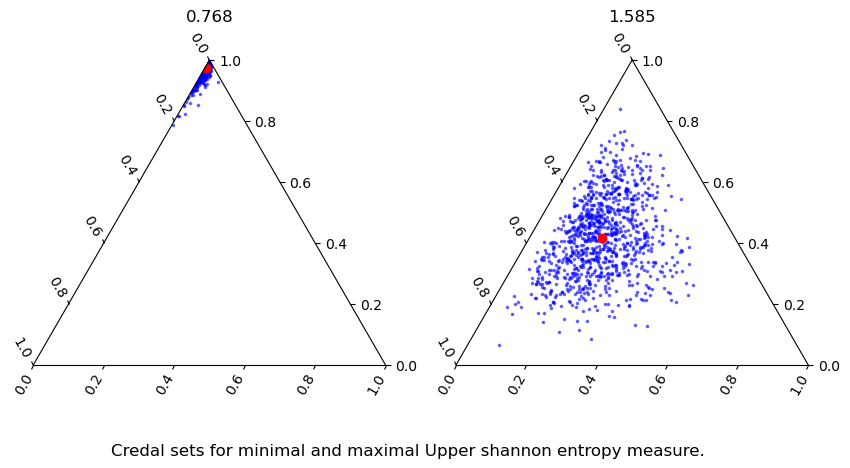

In [132]:
wine_upper_shannon = get_upper_shannon(wine_credal_sets)

name = 'Upper shannon entropy'
plot_uncertainty_triangle(wine_credal_sets, wine_upper_shannon, name)

Describe plot... also plot decision boundaries ??

In [52]:
lower_shannon = get_lower_shannon(credal_sets)

In [53]:
credal_sets[np.argmax(lower_shannon)]

array([[0.185, 0.26 , 0.555],
       [0.39 , 0.143, 0.467],
       [0.181, 0.523, 0.296]])

In [54]:
credal_sets[np.argmin(lower_shannon)]

array([[0.001, 0.028, 0.972],
       [0.305, 0.024, 0.671],
       [0.008, 0.   , 0.992]])

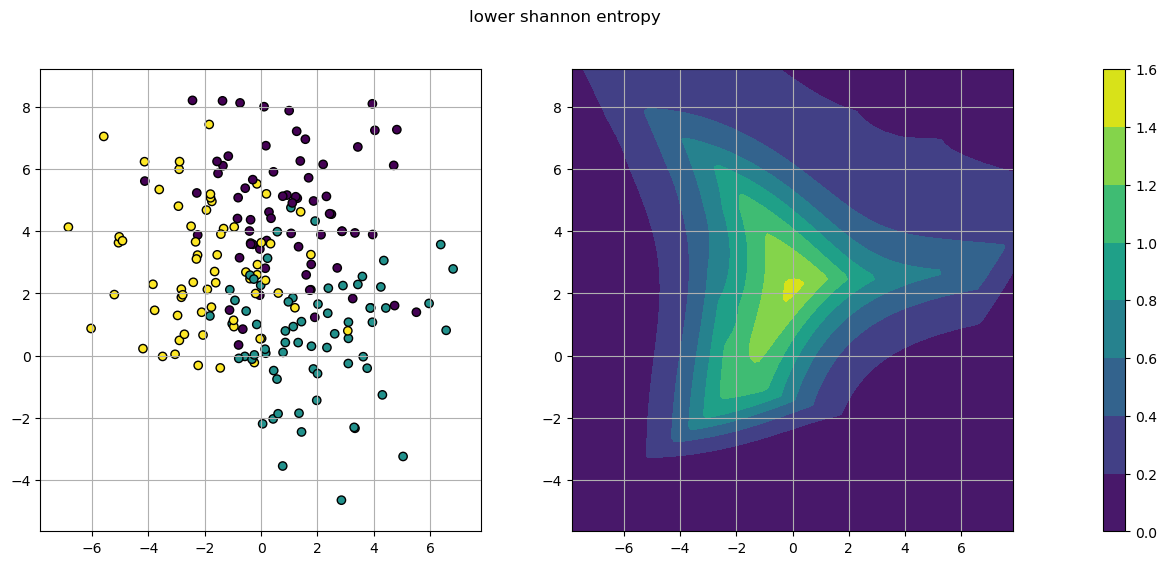

In [55]:
plot_measure_contour(X, y, get_lower_shannon, classifiers, 'lower shannon entropy')

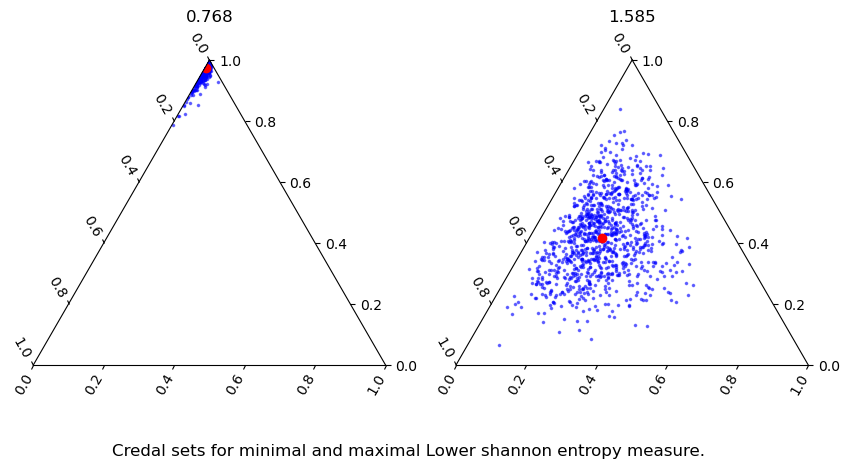

In [133]:
wine_lower_shannon = get_upper_shannon(wine_credal_sets)

name = 'Lower shannon entropy'
plot_uncertainty_triangle(wine_credal_sets, wine_upper_shannon, name)

Based on these measures, the following disaggregations of total uncertainty (\ref{eq:aggregate}) have been proposed \citep{abel_dt06}:

$$
\begin{align}
H^*(Q) & = \big(H^*(Q) - \text{GH}(Q) \big)  + \text{GH}(Q)  \label{eq:unc1} \\
H^*(Q) & = H_*(Q)  + \big(H^*(Q) - H_*(Q) \big)   \label{eq:unc2}
\end{align}
$$

In both cases, upper entropy serves as a measure of total uncertainty $U(Q)$, which is again justified on an axiomatic basis. In the first case, the generalized Hartley measure is used for quantifying epistemic uncertainty, and aleatoric uncertainty is obtained as the difference between total and epistemic uncertainty. In the second case, epistemic uncertainty is specified in terms of the difference between upper and lower entropy.  

We can realize both uncertainty decompositions by combining our previous results:

In [134]:
def decomposition_1(credal_sets):
    
    gh = get_gh_measure(credal_sets)
    us = get_upper_shannon(credal_sets)
    
    aleatoric = us - gh
    epistemic = gh
    
    return aleatoric, epistemic

In [135]:
def decomposition_2(credal_sets):
    
    ls = get_lower_shannon(credal_sets)
    us = get_upper_shannon(credal_sets)
    
    aleatoric = ls
    epistemic = us - ls
    
    return aleatoric, epistemic

In [136]:
aleatoric1, epistemic1 = decomposition_1(credal_sets)

In [137]:
aleatoric2, epistemic2 = decomposition_2(credal_sets)

We can look at the credal sets of the queries with maximal epistemic and maximal aleatoric uncertainty. In case of the high epistemic uncertainty, we can see that the entropy of the individual distributions is not very high and it wouldnt be a problem to make a prediction based on only one of them, however the uncertainty comes from their strong disagreement:

In [138]:
# epistemic uncertainty estimate decomposition 1
credal_sets[np.argmax(epistemic1)]

array([[0.022, 0.018, 0.96 ],
       [0.88 , 0.033, 0.087],
       [0.05 , 0.   , 0.95 ]])

In [139]:
# epistemic uncertainty estimate decomposition 2
credal_sets[np.argmax(epistemic2)]

array([[0.001, 0.028, 0.972],
       [0.305, 0.024, 0.671],
       [0.008, 0.   , 0.992]])

When looking at the credal sets with the highest aleatoric uncertainty we can see that the entropy within the single distributions is very high which means it also might be difficult to make a prediction in that area if we could reduce the epistemic uncertainty:

In [140]:
# aleatoric uncertainty estimate decomposition 1
credal_sets[np.argmax(aleatoric1)]

array([[0.035, 0.539, 0.426],
       [0.078, 0.421, 0.501],
       [0.041, 0.526, 0.433]])

In [141]:
#aleatoric uncertainty estimate decomposition 2
credal_sets[np.argmax(aleatoric2)]

array([[0.185, 0.26 , 0.555],
       [0.39 , 0.143, 0.467],
       [0.181, 0.523, 0.296]])

In [156]:
aleatoric1_w, epistemic1_w = decomposition_2(wine_credal_sets)

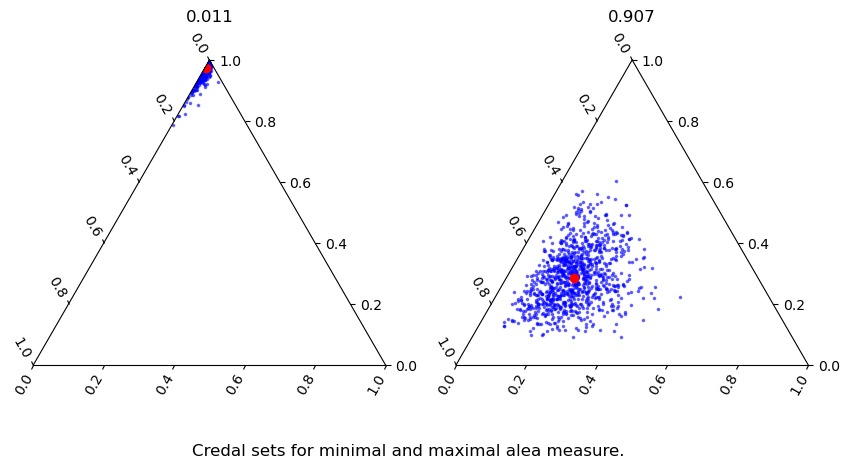

In [157]:
plot_uncertainty_triangle(wine_credal_sets, aleatoric1_w, 'Epistemic uncertainty decomposition')

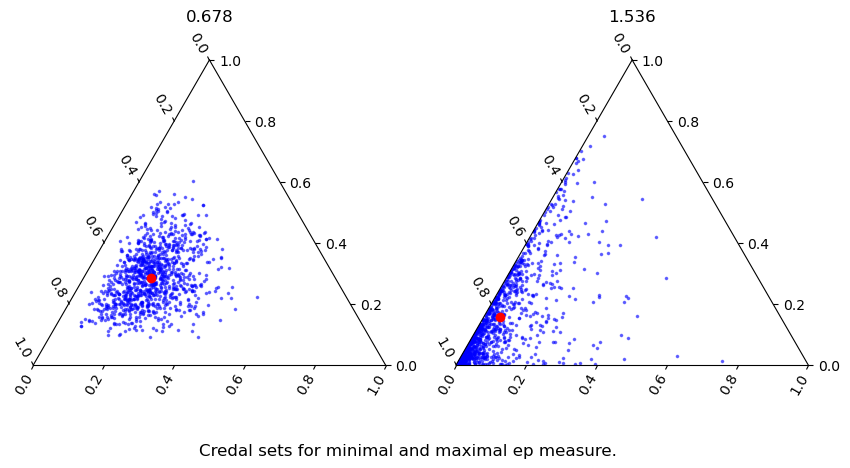

In [158]:

plot_uncertainty_triangle(wine_credal_sets, epistemic1_w, 'Epistemic uncertainty decomposition')

## Set-valued prediction

Credal classifiers are used for "indeterminate" prediction, that is, to produce reliable set-valued predictions that are likely to cover the true outcome. In this regard, the notion of *dominance* plays an important role: An outcome $y$ dominates another outcome $y'$ if $y$ is more probable than $y'$ for each distribution in the credal set, that is,
$$
\begin{align} \label{eq:dominance}
\gamma(y,y', \vec{x}) \defeq
\inf_{h \in C} \frac{p( y \given \vec{x}_q, h)}{p(y' \given \vec{x}_q, h)}  > 1 \, ,
\end{align}
$$
where $C$ is a credal set of hypotheses, and $p( y \given \vec{x}, h)$ the probability of the outcome $y$ (for the query $\vec{x}_q$) under hypothesis $h$. 
The set-valued prediction for a query $\vec{x}_q$ is then given by the set of all non-dominated outcomes $y \in \set{Y}$, i.e., those outcomes that are not dominated by any other outcome.
Practically, the computations are based on the interval-valued probabilities 
$[\underline{p}(y \given \vec{x}_q), \overline{p}(y \given \vec{x}_q)]$
assigned to each class $y \in \set{Y}$, where 
\begin{align} \label{eq:inter_pro}
\underline{p}(y \given \vec{x}_q) \defeq \inf_{h \in C} p(y \given \vec{x}_q, h)\, , \quad \overline{p}(y \given \vec{x}_q) \defeq \sup_{h \in C} p(y \given \vec{x}_q, h) \, .
\end{align}
Note that the upper probabilities $\overline{p}(y \given \vec{x}_q)$ are very much in the spirit of the plausibility degrees (\ref{eq:plaus}).

First we define a function to capture the notion of dominance within a credal set:

In [142]:
def is_dominated(y, yprime, credal_sets):
    
    dominated = np.all(credal_sets[:,:,y] > 
                       credal_sets[:,:,yprime][:,:,np.newaxis],axis=1)
    
    return dominated

In [143]:
def is_dominated2(y, yprime, credal_sets):
    np.seterr(divide='ignore')
 
    infinum = np.min(credal_sets[:,:,y] / 
                     credal_sets[:,:,yprime][:,:,np.newaxis],axis=1) > 1
    
    dominated = infinum > 1
    
    return dominated

In the following credal set class 1 is dominated by class 0, as class probabilities are higher across all distributions in the set. Howver it is not dominated by class 2 since the class probability for 2 in the first distribution isnt higher:

In [144]:
# TODO: use appropriate credal_set

In [145]:
credal_sets[0]

array([[0.762, 0.035, 0.202],
       [0.938, 0.039, 0.023],
       [0.775, 0.033, 0.192]])

In [146]:
is_dominated([0,1],2,credal_sets)[0]

array([ True, False])

We define another function to determine which classes are not dominated across all our credal sets. With this we can then do set valued prediction:

In [147]:
def get_not_dominated(credal_sets):
    
    n_samples, _, n_classes = credal_sets.shape
    
    # Create a matrix to hold the dominance results
    dominance = np.zeros((n_samples, n_classes), dtype=bool)
    
    for yprime in range(n_classes):
        y = np.arange(n_classes) != yprime
        
        # for each sample check if class is dominated by any other
        is_dominated_by = np.any(is_dominated(y, yprime, credal_sets), axis=1)
        
        # class is not dominated if is_dominated is false
        dominance[:, yprime] = ~is_dominated_by
    
    return dominance

In [148]:
def get_set_predictions(credal_sets):
    
    _, _, n_classes = credal_sets.shape
    
    not_dominated = get_not_dominated(credal_sets)
    
    predictions = [np.arange(n_classes)[idx] for idx in not_dominated]
    
    return predictions

In [149]:
set_predictions = get_set_predictions(credal_sets)
set_predictions[0:10]

[array([0]),
 array([1, 2]),
 array([0, 1]),
 array([0, 2]),
 array([2]),
 array([0]),
 array([0]),
 array([1, 2]),
 array([1, 2]),
 array([0])]

We can see that for queries for which we obtained credal sets with higher uncertainty we get set predictions with a higher cardinality while for ones with low uncertainty we only get a point prediction. We can use the previously created uncertainty decomposition to demonstrate that:

In [150]:
aleatoric, epistemic = decomposition_1(credal_sets)

In [73]:
set_predictions[np.argmax(aleatoric)]

array([1, 2])

In [74]:
set_predictions[np.argmax(epistemic)]

array([0, 2])

In [75]:
set_predictions[np.argmin(aleatoric)]

array([0, 2])

In [76]:
set_predictions[np.argmin(epistemic)]

array([1])

In [79]:
def plot_cardinality_contour(X, y, classifiers, title):
    # helper function to uniformly visualize uncertainty measures
    
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
    x_grid = np.linspace(x_min,x_max, 100)
    y_grid = np.linspace(y_min, y_max, 100)
    
    xv, yv = np.meshgrid(x_grid,y_grid)
    
    points = np.column_stack((xv.ravel(), yv.ravel()))
    
    mesh_probabilities = []

    for classifier in classifiers:
        p = classifier.predict_proba(points)
        mesh_probabilities.append(p)

    mesh_credal_sets = np.transpose(np.array(mesh_probabilities), (1,0,2))
    
    set_predictions = get_set_predictions(mesh_credal_sets)
    cardinalities = np.array([len(x) for x in set_predictions])
    measure_res = cardinalities.reshape((100,100))
    
    fig = plt.figure(figsize=(14,6))
    gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    cax = fig.add_subplot(gs[0, 2])
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.grid(True)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    ax2.grid(True)
    
    ax1.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
    contour = ax2.contourf(x_grid, y_grid, measure_res, cmap='viridis')

    cbar = plt.colorbar(contour, cax=cax)

    plt.suptitle(title)
    plt.show()

We again visualize using a countout plot, this time depending on the cardinality of the prediction sets. We can see that in the areas where the classes are clearly seperated we get point predictions. In the areas where no information is available or the clusters overlap the cardinality of the prediction sets is higher.

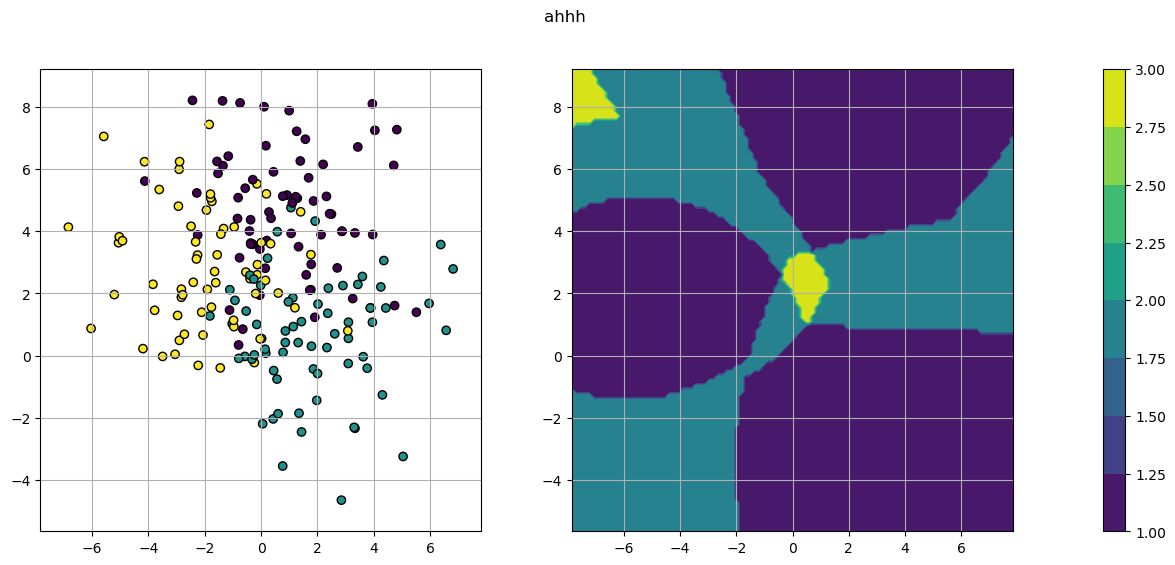

In [88]:
plot_cardinality_contour(X, y, classifiers, 'ahhh')

Now we can also create a set prediction for the wine credal set we obtained at the beginning. We visualize three credal sets for which we received different sized set predictions, in the same way as before:

In [89]:
wine_set_predictions = get_set_predictions(wine_credal_sets)
wine_set_predictions[:10]

[array([0, 2]),
 array([0, 2]),
 array([1, 2]),
 array([0]),
 array([1]),
 array([0]),
 array([1, 2]),
 array([1, 2]),
 array([1]),
 array([1, 2])]

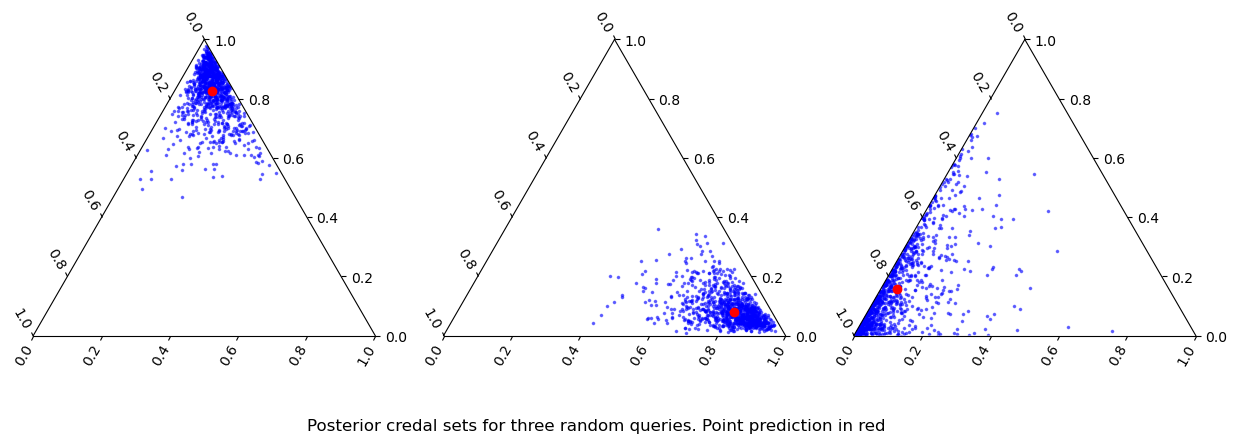

In [109]:
ridx = [np.random.choice(np.argwhere(np.array([len(x) for x in wine_set_predictions])==i)[:,0]) for i in range(1,4)]
create_posterior_plot(wine_credal_sets, point_predictions, ridx)

Interestingly, uncertainty degrees can be derived on the basis of dominance degrees (\ref{eq:dominance}). For example, the following uncertainty score has been proposed by \citet{antonucci2012} in the context of uncertainty sampling for active learning:

$$
\begin{align} \label{eq:scoreNCC}
s(\vec{x}_q) \defeq - \max \big(\gamma(+1, -1, \vec{x}_q ), \gamma(-1, +1, \vec{x}_q ) \big) \, .
\end{align}
$$

For data sets with more than two classes the score generalizes as follows:

$$
- \sum_{c' \in \mathcal{C}} \sum_{c'' \in \mathcal{C} \setminus \{c'\}} \max[\gamma(c', c''), \gamma(c'', c')]
$$

This degree is low if one of the outcomes strongly dominates the other one, but high if this is not the case. It is closely related to the degree of epistemic uncertainty in (\ref{eq:ep}) to be discussed in Section \ref{sec:uqnl}, but also seems to capture some aleatoric uncertainty. In fact, $s(\vec{x}_q)$ increases with both, the width of the interval $[\underline{p}(y \given \vec{x}_q) , \overline{p}(y \given \vec{x}_q)]$ as well as the closeness of its middle point to $\nicefrac{1}{2}$.

In [110]:
def get_dominance_scores(credal_sets):
    
    n_samples, _, n_classes = credal_sets.shape
    
    # Create a matrix to hold the dominance results
    scores = []
    
    for yprime in range(n_classes):
        y = np.arange(n_classes) != yprime
        
        a = np.min(credal_sets[:, :,yprime][:,:,np.newaxis] / credal_sets[:, :, y], axis=1)
        b = np.min(credal_sets[:, :,y] / credal_sets[:, :, yprime][:,:,np.newaxis],axis=1)
        

        s = np.sum(np.max(np.array([a, b]), axis=0), axis=1)
        
        scores.append(s)
        
    scores = -np.sum(np.array(scores),axis=0)
    
    return scores

We can also compute the uncertainty degrees on our credal sets:

In [151]:
np.seterr(all='ignore')
wine_dominance_scores = get_dominance_scores(wine_credal_sets)

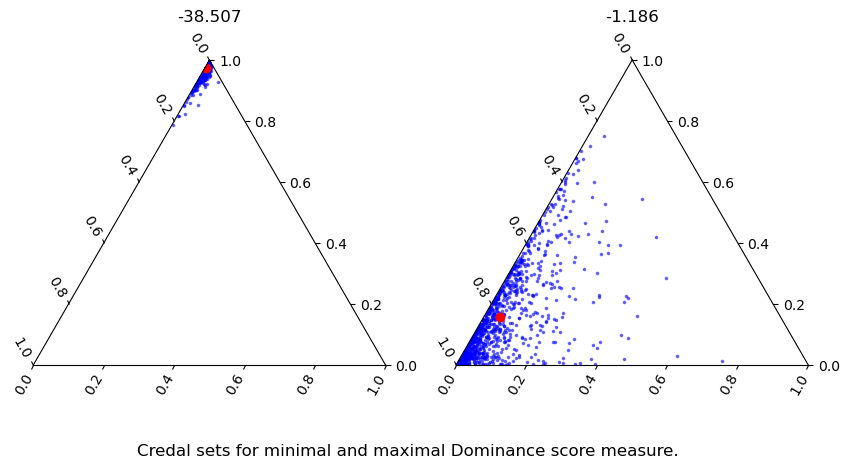

In [152]:
plot_uncertainty_triangle(wine_credal_sets, wine_dominance_scores, 'Dominance score')